## Автоматизация отчетности

<b>Цель:</b> создать единый отчет по основным данным ленты новостей и сервиса отправки сообщений

<b>Задачи:<b>
 - Создать бот в телеграмм с помощью BotFather;
 - Отправка ботом ежедневного отчета по основным метрикам;
 - Отправка графиков, отображающих динамику метрик;
 - Отчет должен приходить ежедневно в 11:00;
 
Код сборки и отправки отчета:

In [3]:
import telegram
import pandas as pd
import pandahouse as ph
import matplotlib.pyplot as plt
import seaborn as sns
import io
from airflow import DAG
from datetime import datetime, timedelta, date
from airflow.decorators import dag, task
from IPython.display import Image

default_args = {
    'owner': 'd-tsykarev-13',
    'depends_on_past': False,
    'retries': 2,
    'retry_delay': timedelta(minutes=5),
    'start_date': datetime(2022, 12, 15)
}

schedule_interval = '0 11 * * *'

@dag(default_args=default_args, schedule_interval=schedule_interval, catchup=False, tags=['d-tsykarev'])
def feed_messanger_stat_tsykarev():
    
    #Читаем основную таблицу с разбивкой по пользователям, дням и действиям
    @task
    def load_main_df():
        connection = {'host': 'https://clickhouse.lab.karpov.courses',
                              'database':'simulator_20221120',
                              'user':'student', 
                              'password':'dpo_python_2020'
                             }

        query = '''
        SELECT user_id,
                toDate(time) as date,
                action,
                count(post_id) as action_number
        FROM simulator_20221120.feed_actions
        WHERE (toDate(time) >= today() - INTERVAL 14 day) AND (toDate(time) != today())
        GROUP BY user_id, toDate(time), action

        UNION ALL

        SELECT user_id,
                toDate(time),
                'message' as action,
                count(reciever_id) as action_number
        FROM simulator_20221120.message_actions
        WHERE (toDate(time) >= today() - INTERVAL 14 day) AND (toDate(time) != today())
        GROUP BY user_id, toDate(time)
        '''

        df = ph.read_clickhouse(query, connection=connection)
        return df

    #Читаем таблицу с датой первого визита пользователя
    @task()
    def load_first_dates():
        connection = {'host': 'https://clickhouse.lab.karpov.courses',
                          'database':'simulator_20221120',
                          'user':'student', 
                          'password':'dpo_python_2020'
                         }

        query = '''
        SELECT user_id,
                MIN(first_date) as first_date
        FROM
            (SELECT user_id,
                    MIN(toDate(time)) as first_date
            FROM simulator_20221120.message_actions
            GROUP BY user_id

            UNION ALL

            SELECT user_id,
                    MIN(toDate(time)) as first_date
            FROM simulator_20221120.feed_actions
            GROUP BY user_id)
        GROUP BY user_id
        '''

        first_dates = ph.read_clickhouse(query, connection=connection)
        return first_dates

    ### Объединяем полученные таблицы
    @task()
    def transform_merge(df, first_dates):
        df = df.merge(first_dates, how='inner', on='user_id')
        return df

    ### Создаем таблицу с dau
    @task()
    def transfrom_make_dau(df):
        dau = df.groupby('date', as_index=False).agg({'user_id':'nunique'}).rename({'user_id':'unique_users'}, axis=1)
        return dau

    ### Находим старых и новых пользователей по дням
    @task()
    def transform_find_types(df):
        df['is_old_user'] = df['first_date'] < df['date']
        daily_users = df.groupby(['date', 'is_old_user'], as_index=False)\
        .agg({'user_id':'nunique'})\
        .rename({'user_id':'unique_users'}, axis=1)
        daily_users = daily_users.pivot(index='date', columns='is_old_user', values='unique_users').reset_index().fillna(0)
        return daily_users

    ### Находим статистику по лайкам, просмотрам, сообщениям
    @task()
    def transform_find_actions(df, dau):
        views_likes_messages = df.groupby(['date', 'action'], as_index=False).agg({'action_number':'sum'})
        views_likes_messages = views_likes_messages.merge(dau, on = 'date')
        views_likes_messages['avg_action_number'] = views_likes_messages['action_number']/views_likes_messages['unique_users']
        return views_likes_messages


    ### Готовим таблицу для отображения Retention
    @task()
    def transform_heat_data(df):
        ## Находим когорты
        cohorts = df.groupby('first_date', as_index=False)\
                .agg({'user_id':'nunique'})\
                .rename({'user_id':'unique_users'}, axis=1)
        cohorts['cohort'] = cohorts['first_date'].dt.strftime('%d.%m')

        ## Присваиваем когорты пользователям
        short_df = df[df['first_date'].dt.date >= date.today() - timedelta(days=14)].merge(cohorts, on='first_date')

        heat_df = short_df.groupby(['cohort','date'], as_index=False)\
                            .agg({'user_id':'nunique', 'unique_users':'max'})\
                            .rename({'user_id':'current_users'}, axis=1)

        heat_df['share']=heat_df['current_users']/heat_df['unique_users']
        heat_df['date'] = heat_df['date'].dt.strftime('%d.%m')
        heat_df = heat_df.pivot(index='cohort', columns='date', values='share')
        return heat_df
    
    ### Готовим таблицу для CTR
    @task()
    def transform_count_ctr(views_likes_messages):
        ctr_df = views_likes_messages.pivot(index='date', columns='action', values='action_number').reset_index()
        ctr_df['ctr'] = ctr_df['like']/ctr_df['view']
        return ctr_df
    
    @task()
    def load(df, dau, views_likes_messages, heat_df, daily_users, ctr_df):
        ### Находим прилипаемость
        MAU = len(
            df[
                (df['date'].dt.date <= date.today() - timedelta(days=1))&
                (df['date'].dt.date >= date.today() - timedelta(days=30))
            ]['user_id'].unique()
        )
        DAU = dau[dau['date'].dt.date == date.today() - timedelta(days=1)]['unique_users'].iloc[0]
        STICKINESS = DAU/MAU

        ### Подключаемся к боту
        my_token = '5817720440:AAGEIaTOdG1oZkbVURVBsLNMMzcfV8Vr814'
        bot = telegram.Bot(token=my_token)
        chat_id = -817095409

        ### ФОрмируем сообщение
        text = 'Дата: {} \n DAU: {} \n Stickiness: {:.2f}\n Views: {} \n Likes: {}\n CTR: {:.2%} \n Messages: {}'\
        .format(
            date.today() - timedelta(days=1), 
            dau[dau['date'].dt.date == date.today() - timedelta(days=1)]['unique_users'].iloc[0],
            STICKINESS,
            views_likes_messages[
                (views_likes_messages['date'].dt.date == date.today() - timedelta(days=1))&
                (views_likes_messages['action'] == 'view')
                                ]['action_number'].iloc[0],
            views_likes_messages[
                (views_likes_messages['date'].dt.date == date.today() - timedelta(days=1))&
                (views_likes_messages['action'] == 'like')
                                ]['action_number'].iloc[0],
            ctr_df[ctr_df['date'].dt.date == date.today() - timedelta(days=1)]['ctr'].iloc[0],
            views_likes_messages[
                (views_likes_messages['date'].dt.date == date.today() - timedelta(days=1))&
                (views_likes_messages['action'] == 'message')
                                ]['action_number'].iloc[0] 
            )

        ### Отправляемм сообщение в чат
        bot.sendMessage(chat_id=-817095409, text=text)

        ### Создаем графики
        fig, axs = plt.subplots(2, 1)
        fig.set_size_inches(20, 20)
        fig.suptitle('Статистика ленты и мессенджера за 14 дней', fontsize=16)

        ## График DAU в разбивке на старых и новых пользователей
        axs[0].stackplot(daily_users.date, daily_users[True], daily_users[False], labels=['Old', 'New'])
        axs[0].set_title('DAU по типу пользователей')
        axs[0].legend(loc='upper left')
        axs[0].set_ylabel('Пользователи')

        ## График уровня Retention
        sns.heatmap(heat_df, ax=axs[1])
        axs[1].set_title('Retention rate')
        axs[1].set_xlabel('')
        
        ###Отправляем сообщение в чат
        plot_object = io.BytesIO()
        plt.savefig(plot_object)
        plot_object.seek(0)
        plot_object.name = 'feed_data_plot.png'
        plt.close()
        bot.sendPhoto(chat_id=-817095409, photo=plot_object)
        
        ### Создаем графики
        fig, axs = plt.subplots(3, 1)
        fig.set_size_inches(20, 20)
        fig.suptitle('Статистика ленты и мессенджера за 14 дней', fontsize=16)
        
        ## График CTR
        sns.lineplot(data=ctr_df, x='date', y='ctr', ax=axs[0])
        axs[0].set_title('CTR')
        axs[0].set_xlabel('')

        ## График действий
        sns.lineplot(data=views_likes_messages, x='date', y='action_number', hue='action', ax = axs[1])
        axs[1].set_title('Действия пользователй')
        axs[1].set_xlabel('')

        ## Нормированный график действий
        sns.lineplot(data=views_likes_messages, x='date', y='avg_action_number', hue='action', ax= axs[2])
        axs[2].set_title('Нормированные действия пользователй')

        ###Отправляем сообщение в чат
        plot_object = io.BytesIO()
        plt.savefig(plot_object)
        plot_object.seek(0)
        plot_object.name = 'feed_data_plot.png'
        plt.close()
        bot.sendPhoto(chat_id=-817095409, photo=plot_object)

    first_dates = load_first_dates()
    df = load_main_df()
    df = transform_merge(df, first_dates)
    dau = transfrom_make_dau(df)
    daily_users = transform_find_types(df)
    views_likes_messages = transform_find_actions(df, dau)
    heat_df = transform_heat_data(df)
    ctr_df = transform_count_ctr(views_likes_messages)
    load(df, dau, views_likes_messages, heat_df, daily_users, ctr_df)
    
feed_messanger_stat_tsykarev = feed_messanger_stat_tsykarev()


## Скриншоты отправляемого отчета:

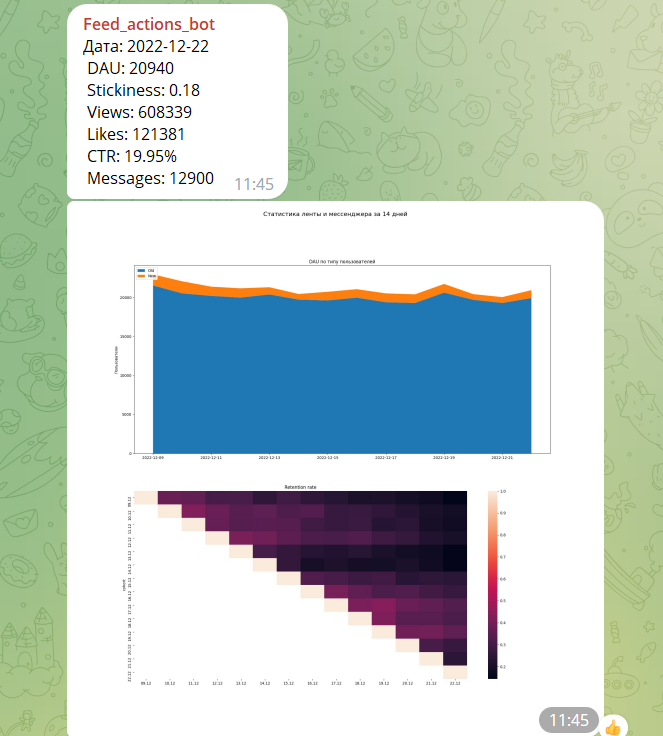

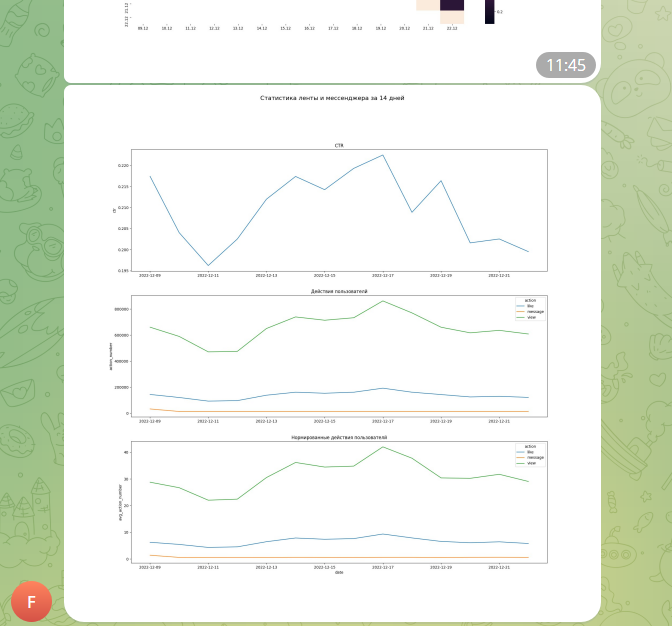

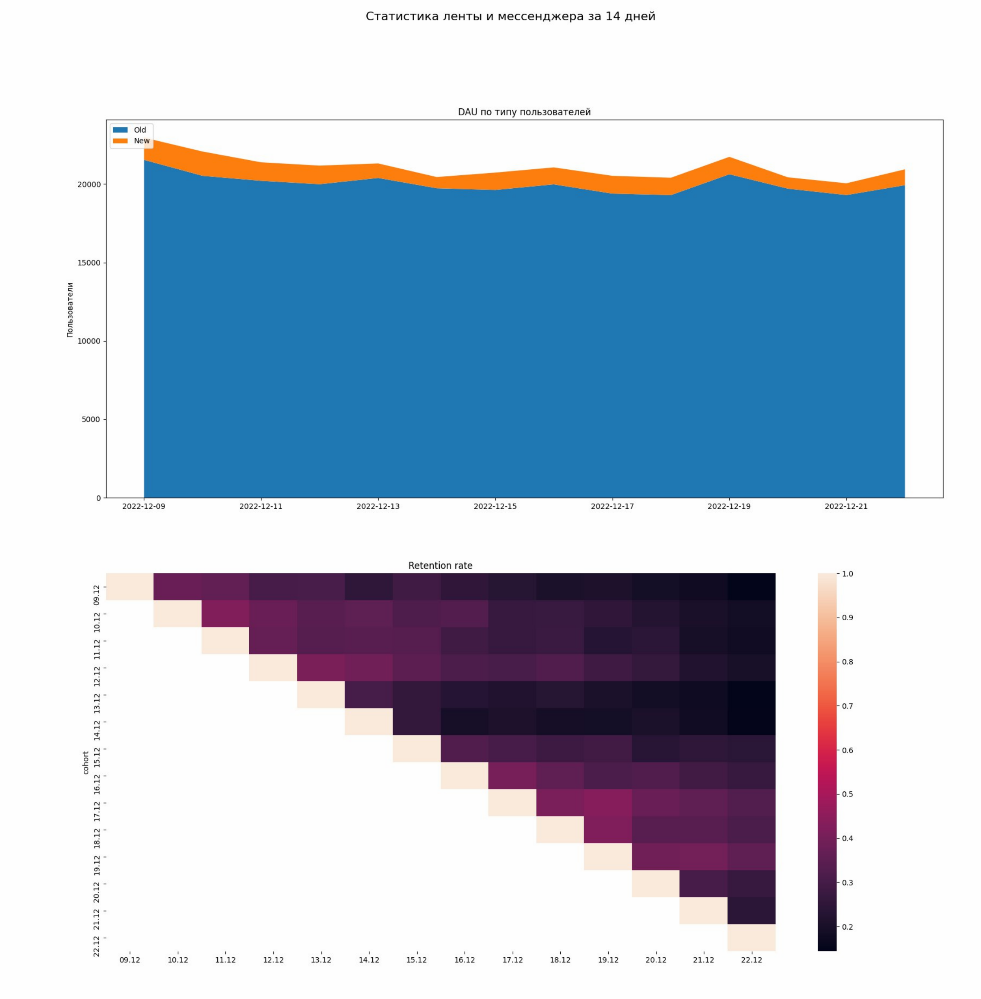

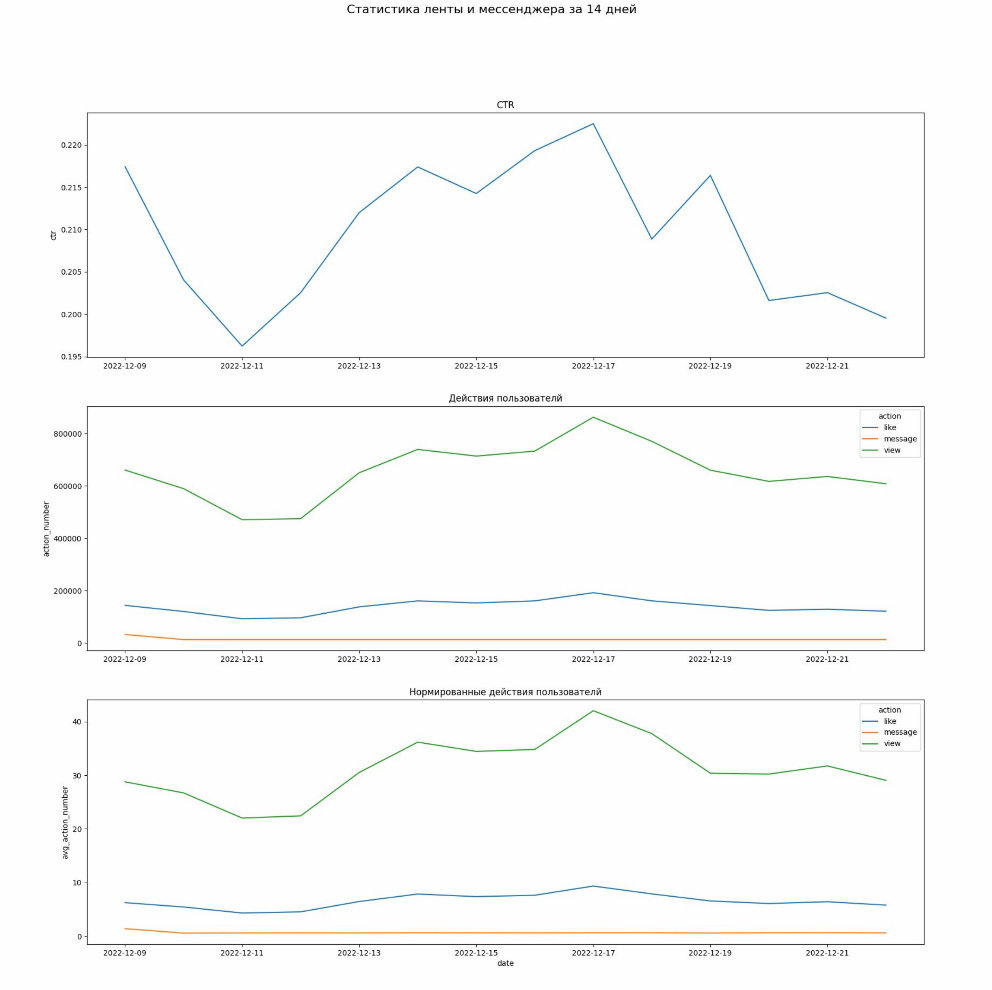

In [12]:
for i in range(8, 12):
    display(Image("Screenshot_{:.0f}.png".format(i)))